In [32]:
import numpy as np
import pandas as pd   
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'total_univ']
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
# dance_years 매핑
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# 원-핫 인코딩
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'

]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=float)

# -------------------------
# 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# 상관계수 높은 변수 사전 삭제 (전처리 단계)
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat','peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')


# -------------------------
# sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 설명용 출력
# -------------------------
print("✅ 최종 데이터셋 컬럼 수:", df.shape[1])
print("sat 중위수:", sat_median)
print(df[['sat', 'sat_group']].head())



✅ 최종 데이터셋 컬럼 수: 200
sat 중위수: 4.0
    sat  sat_group
0  4.00          1
1  4.50          1
2  3.00          0
3  3.00          0
4  4.75          1


In [8]:
# has_major_income == 0인 경우 세부문항 결측 처리
income_subitems = [
    'income_class', 'income_broadcast', 'income_contest', 'income_studio', 
    'income_perf', 'income_creator', 'income_choreo', 
    'info_dept', 'info_online', 'info_career_center', 'info_family', 
    'info_friends', 'info_academy', 'info_self', 
    'help_financial', 'help_resume', 'help_career', 'help_social', 'help_no'
]

# has_major_income == 0인 경우 세부문항 0 처리
df.loc[df['has_major_income'] == 0, income_subitems] = 0

# 확인
df.loc[df['has_major_income']==0, income_subitems].head()




,income_class,income_broadcast,income_contest,income_studio,income_perf,income_creator,income_choreo,info_dept,info_online,info_career_center,info_family,info_friends,info_academy,info_self,help_financial,help_resume,help_career,help_social,help_no
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# has_major_income == 1인 사람만 분석
df_sub = df[df['has_major_income'] == 1][income_subitems].copy()

# NaN을 0으로 변환
df_sub = df_sub.fillna(0)

# 각 문항별 응답 분포
for col in df_sub.columns:
    print(f"\n--- {col} ---")
    counts = df_sub[col].value_counts()  # 이제 NaN 없음
    percents = df_sub[col].value_counts(normalize=True) * 100
    summary = pd.DataFrame({'count': counts, 'percent': percents.round(2)})
    display(summary)



--- income_class ---


,count,percent
income_class,,
1.0,131,69.31
0.0,58,30.69



--- income_broadcast ---


,count,percent
income_broadcast,,
0.0,152,80.42
1.0,37,19.58



--- income_contest ---


,count,percent
income_contest,,
1.0,105,55.56
0.0,84,44.44



--- income_studio ---


,count,percent
income_studio,,
0.0,166,87.83
1.0,23,12.17



--- income_perf ---


,count,percent
income_perf,,
1.0,151,79.89
0.0,38,20.11



--- income_creator ---


,count,percent
income_creator,,
0.0,155,82.01
1.0,34,17.99



--- income_choreo ---


,count,percent
income_choreo,,
0.0,160,84.66
1.0,29,15.34



--- info_dept ---


,count,percent
info_dept,,
0.0,116,61.38
1.0,73,38.62



--- info_online ---


,count,percent
info_online,,
0.0,106,56.08
1.0,83,43.92



--- info_career_center ---


,count,percent
info_career_center,,
0.0,174,92.06
1.0,15,7.94



--- info_family ---


,count,percent
info_family,,
0.0,169,89.42
1.0,20,10.58



--- info_friends ---


,count,percent
info_friends,,
1.0,127,67.2
0.0,62,32.8



--- info_academy ---


,count,percent
info_academy,,
1.0,119,62.96
0.0,70,37.04



--- info_self ---


,count,percent
info_self,,
0.0,163,86.24
1.0,26,13.76



--- help_financial ---


,count,percent
help_financial,,
4.0,67,35.45
3.0,46,24.34
5.0,39,20.63
2.0,24,12.70
1.0,10,5.29
0.0,3,1.59



--- help_resume ---


,count,percent
help_resume,,
4.0,66,34.92
5.0,61,32.28
3.0,45,23.81
2.0,12,6.35
0.0,4,2.12
1.0,1,0.53



--- help_career ---


,count,percent
help_career,,
3.0,56,29.63
4.0,54,28.57
5.0,54,28.57
2.0,16,8.47
1.0,5,2.65
0.0,4,2.12



--- help_social ---


,count,percent
help_social,,
4.0,71,37.57
5.0,61,32.28
3.0,41,21.69
2.0,10,5.29
1.0,3,1.59
0.0,3,1.59



--- help_no ---


,count,percent
help_no,,
5.0,95,50.26
4.0,45,23.81
3.0,34,17.99
2.0,9,4.76
0.0,5,2.65
1.0,1,0.53


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


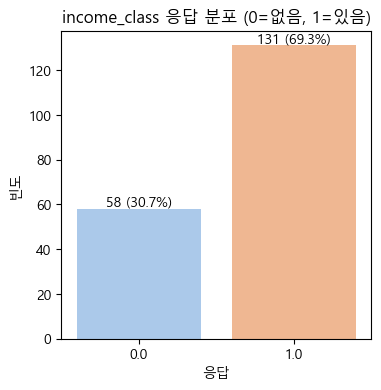

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


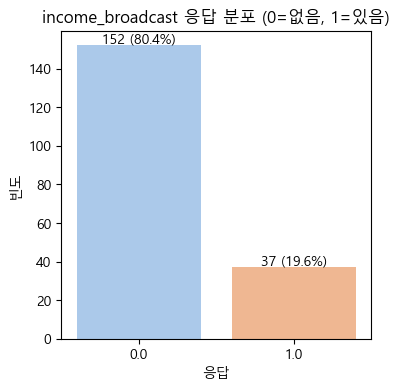

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


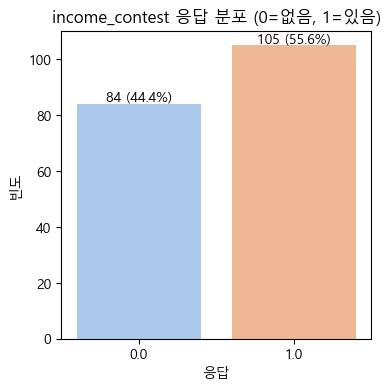

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


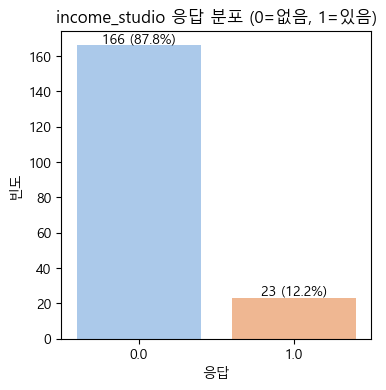

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


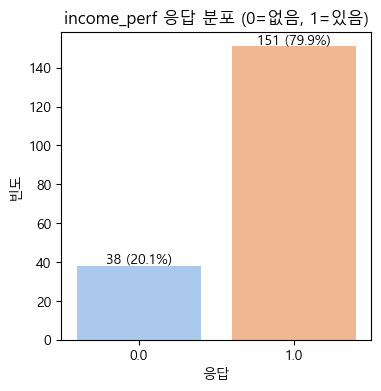

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


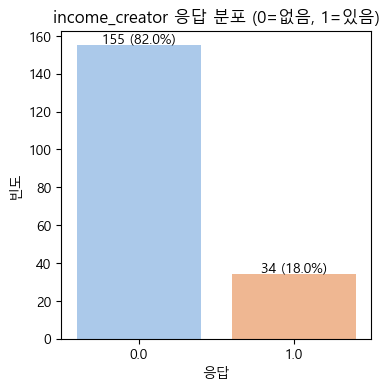

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


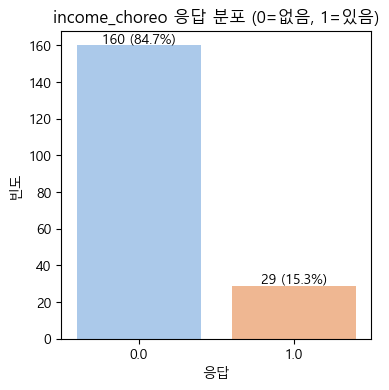

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


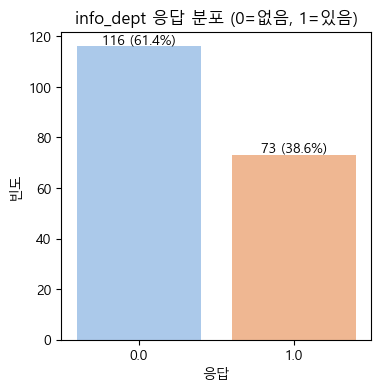

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


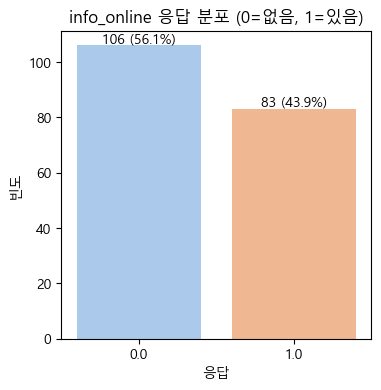

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


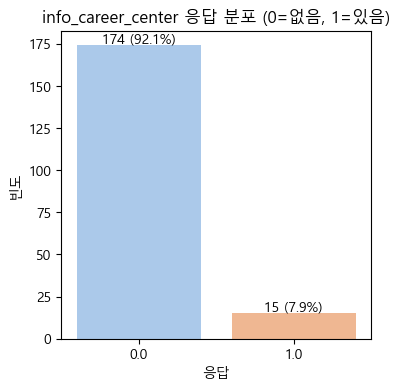

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


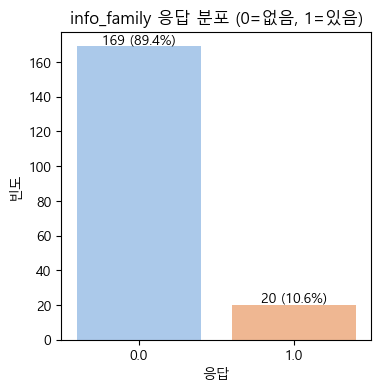

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


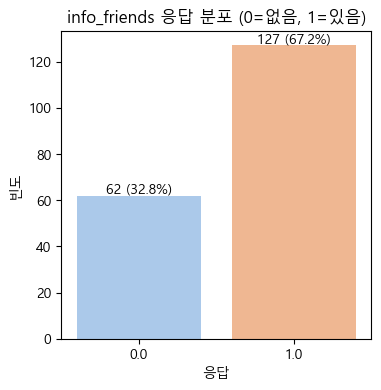

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


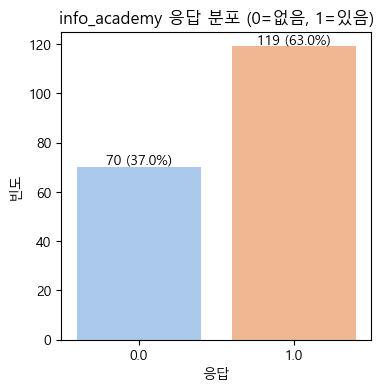

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


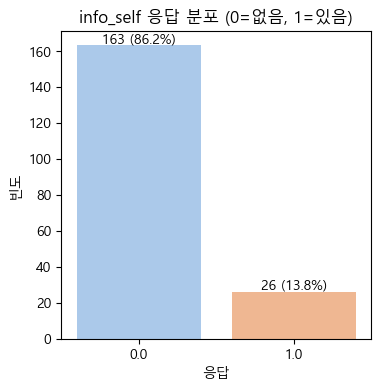

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


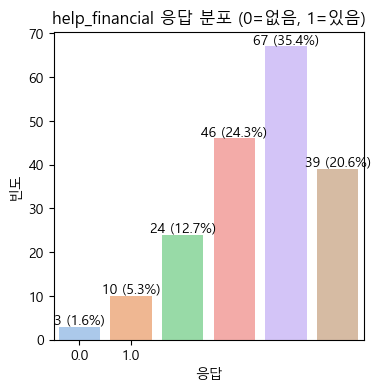

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


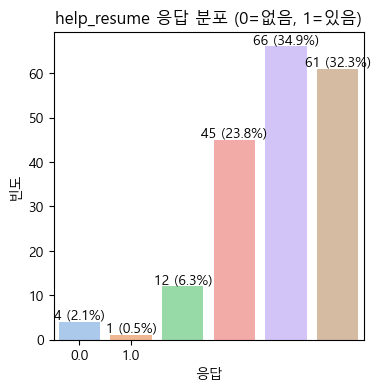

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


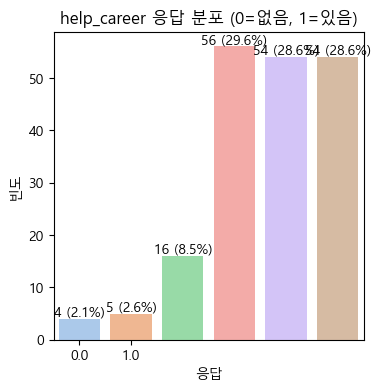

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


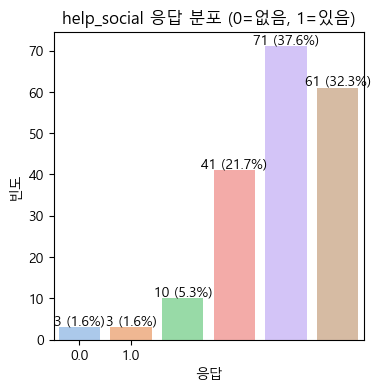

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\267983033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_sub, palette="pastel")


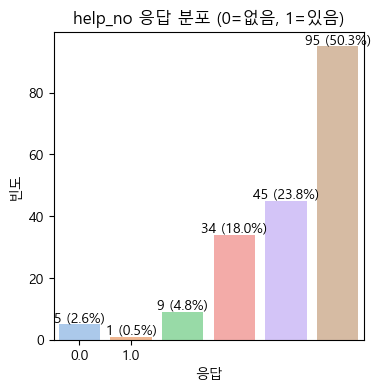

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# has_major_income == 1인 사람만 분석
df_sub = df[df['has_major_income'] == 1][income_subitems].copy()
df_sub = df_sub.fillna(0)  # NaN을 0으로 변환

for col in df_sub.columns:
    plt.figure(figsize=(4,4))
    ax = sns.countplot(x=col, data=df_sub, palette="pastel")
    plt.title(f"{col} 응답 분포 (0=없음, 1=있음)")
    plt.xlabel("응답")
    plt.ylabel("빈도")

    # 막대 위에 count와 percent 표시
    total = len(df_sub)
    for p in ax.patches:
        count = int(p.get_height())
        percent = count / total * 100
        ax.annotate(f'{count} ({percent:.1f}%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.xticks([0,1])
    plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\670088804.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_help, palette="pastel")


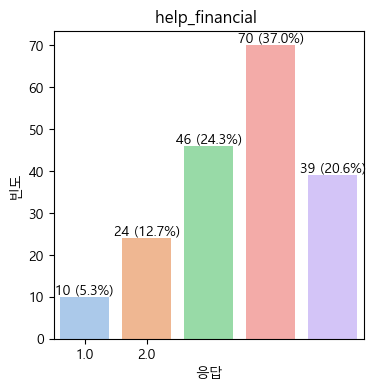

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\670088804.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_help, palette="pastel")


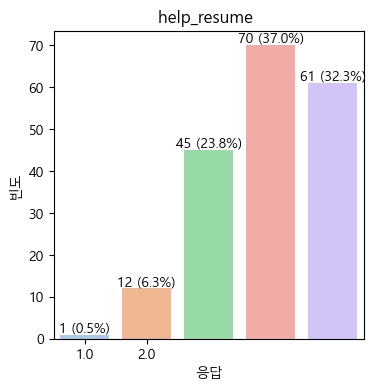

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\670088804.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_help, palette="pastel")


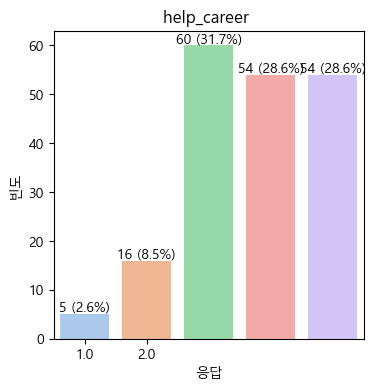

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\670088804.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_help, palette="pastel")


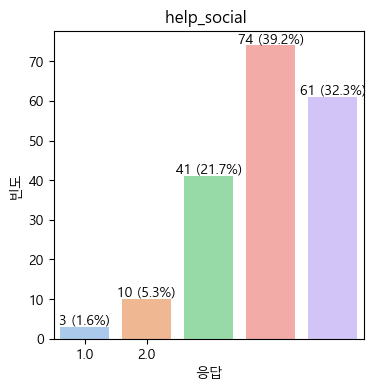

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\670088804.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df_help, palette="pastel")


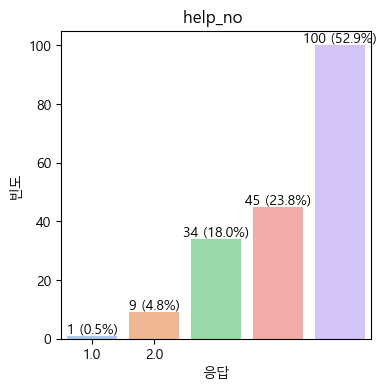

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 분석할 컬럼
help_cols = ['help_financial', 'help_resume', 'help_career', 'help_social', 'help_no']

# has_major_income == 1인 사람만
df_help = df[df['has_major_income'] == 1][help_cols].copy()

# 결측값을 각 컬럼의 최빈값으로 채우기
for col in help_cols:
    mode_val = df_help[col].mode()[0]
    df_help[col] = df_help[col].fillna(mode_val)

# 막대그래프 시각화
for col in help_cols:
    plt.figure(figsize=(4,4))
    ax = sns.countplot(x=col, data=df_help, palette="pastel")
    plt.title(f"{col} ")
    plt.xlabel("응답")
    plt.ylabel("빈도")

    total = len(df_help)
    # 막대 위에 count + percent 표시
    for p in ax.patches:
        count = int(p.get_height())
        percent = count / total * 100
        ax.annotate(f'{count} ({percent:.1f}%)',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)
    plt.xticks([0,1])
    plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\1471899224.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=univ_counts.index.str.replace('univ_factor_',''),


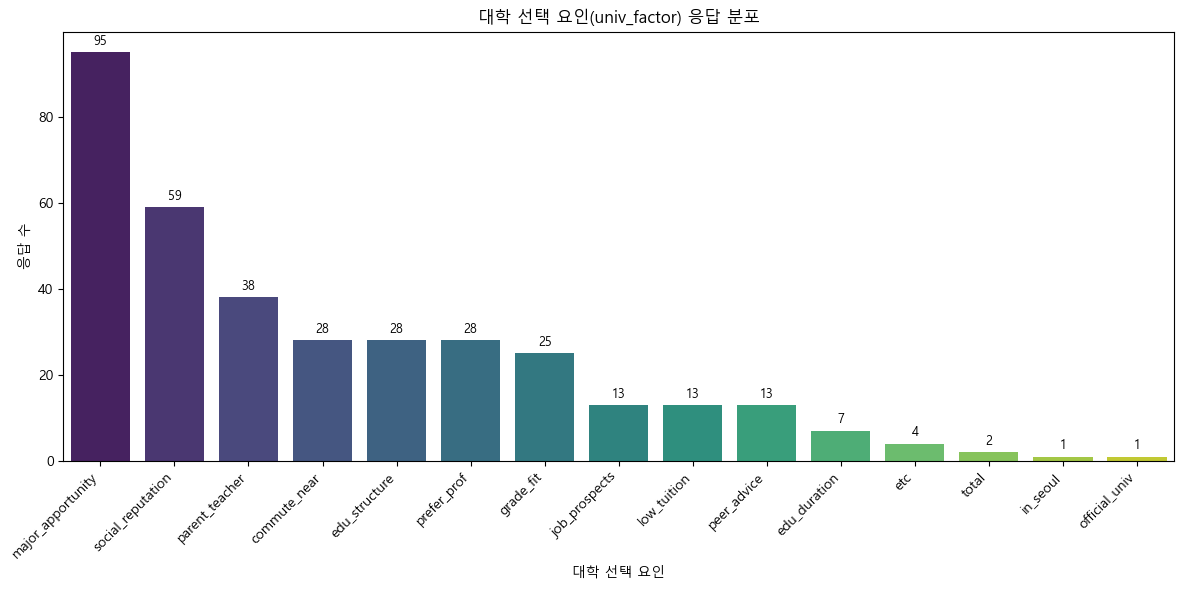

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# univ_factor 관련 컬럼 선택
univ_cols = [col for col in df.columns if col.startswith('univ_factor_')]

# 각 카테고리별 응답 수 계산
univ_counts = df[univ_cols].sum().sort_values(ascending=False)

# 막대그래프 그리기
plt.figure(figsize=(12,6))
sns.barplot(x=univ_counts.index.str.replace('univ_factor_',''), 
            y=univ_counts.values, palette='viridis')

plt.title("대학 선택 요인(univ_factor) 응답 분포")
plt.xlabel("대학 선택 요인")
plt.ylabel("응답 수")
plt.xticks(rotation=45, ha='right')

# 막대 위에 수치 표시
for i, v in enumerate(univ_counts.values):
    plt.text(i, v + 1, str(int(v)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\2115206149.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


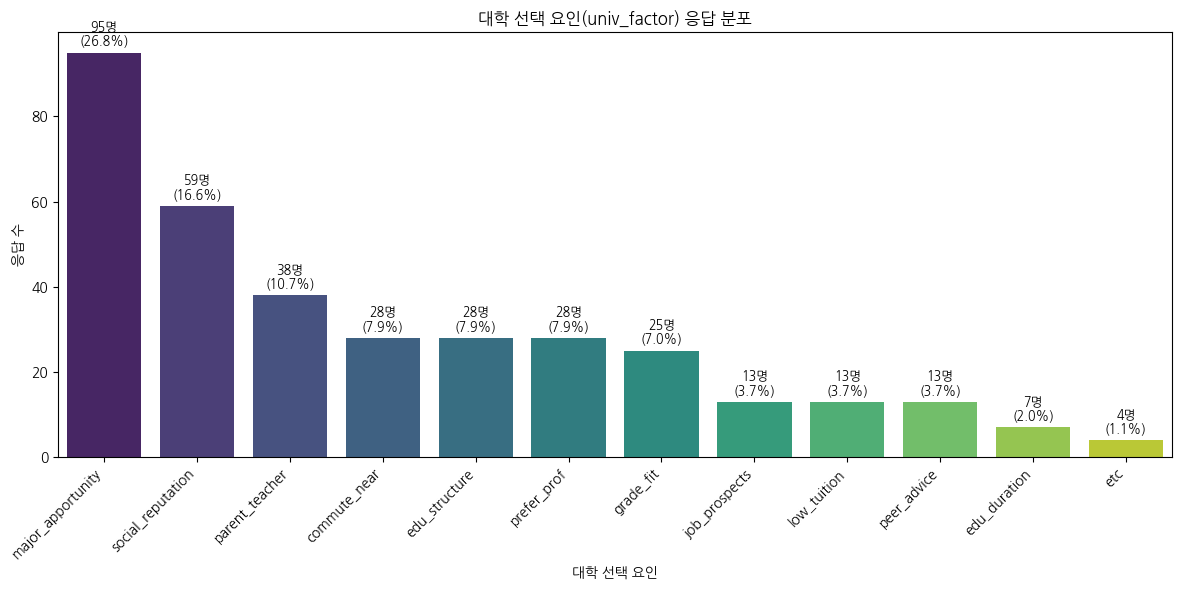

In [33]:
import pandas as pd

# 통합 대상 컬럼 지정
etc_cols = ['univ_factor_official_univ', 'univ_factor_in_seoul', 'univ_factor_total']

# 새 컬럼 'univ_factor_etc' 생성: 세 항목 중 하나라도 1이면 1
df['univ_factor_etc'] = df[etc_cols].max(axis=1)

# 기존 항목 삭제
df = df.drop(columns=etc_cols)

# 분포 다시 확인
univ_cols = [col for col in df.columns if col.startswith('univ_factor_')]
univ_counts = df[univ_cols].sum().sort_values(ascending=False)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(
    x=univ_counts.index.str.replace('univ_factor_', ''), 
    y=univ_counts.values, 
    palette='viridis'
)

plt.title("대학 선택 요인(univ_factor) 응답 분포")
plt.xlabel("대학 선택 요인")
plt.ylabel("응답 수")
plt.xticks(rotation=45, ha='right')

# 막대 위에 숫자 + 퍼센트 표시
total = len(df)
for i, v in enumerate(univ_counts.values):
    pct = v / total * 100
    plt.text(i, v + 1, f"{int(v)}명\n({pct:.1f}%)", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\1306545548.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


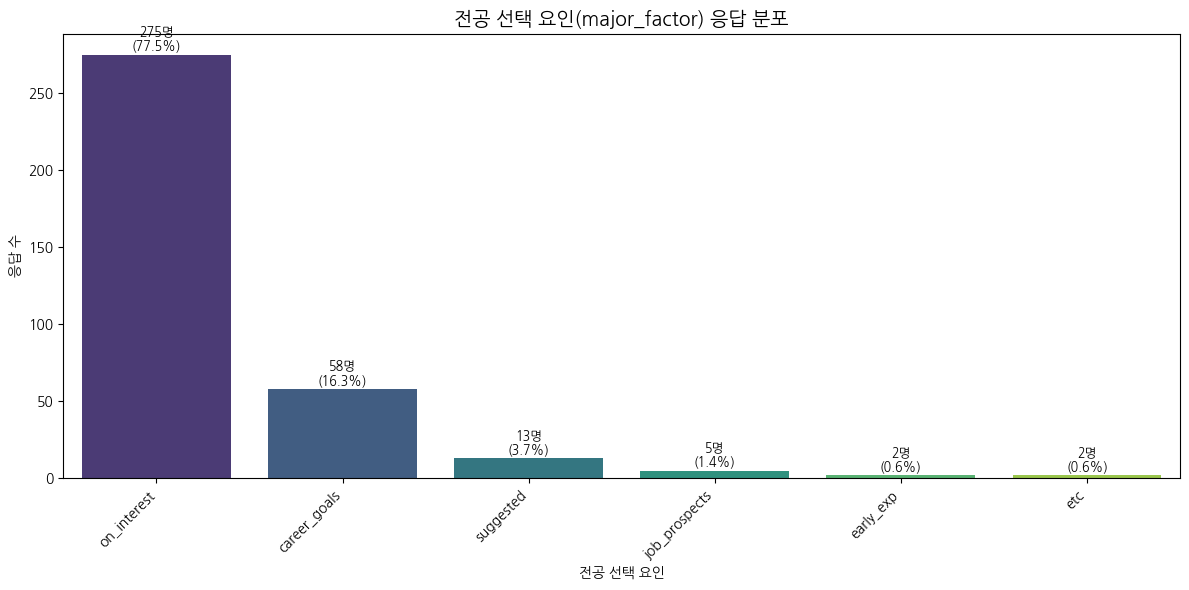

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd

# ✅ 통합 대상 컬럼 지정
major_etc_cols = ['major_factor_official_univ', 'major_factor_total']

# ✅ 새 컬럼 생성: 두 항목 중 하나라도 1이면 1
df['major_factor_etc'] = df[major_etc_cols].max(axis=1)

# ✅ 기존 항목 삭제
df = df.drop(columns=major_etc_cols)

# ✅ 통합 후 분포 확인
major_cols = [col for col in df.columns if col.startswith('major_factor_')]
major_counts = df[major_cols].sum().sort_values(ascending=False)

# ✅ 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(
    x=major_counts.index.str.replace('major_factor_', ''), 
    y=major_counts.values, 
    palette='viridis'
)

plt.title("전공 선택 요인(major_factor) 응답 분포", fontsize=14)
plt.xlabel("전공 선택 요인")
plt.ylabel("응답 수")
plt.xticks(rotation=45, ha='right')

# 막대 위에 응답 수 + 비율 표시
total = len(df)
for i, v in enumerate(major_counts.values):
    pct = v / total * 100
    plt.text(i, v + 1, f"{int(v)}명\n({pct:.1f}%)", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\2970761245.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.str.replace(f"{prefix}_", ""), y=counts.values, palette="viridis")


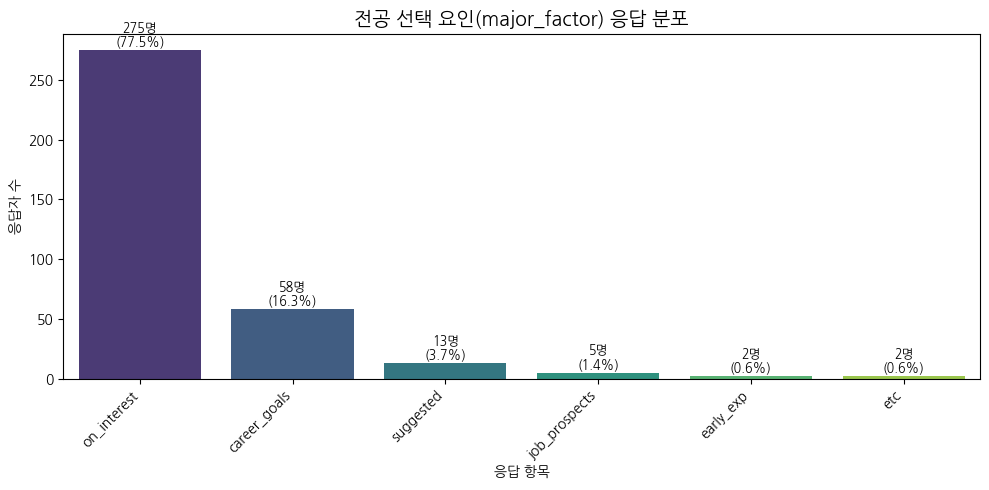

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\2970761245.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.str.replace(f"{prefix}_", ""), y=counts.values, palette="viridis")


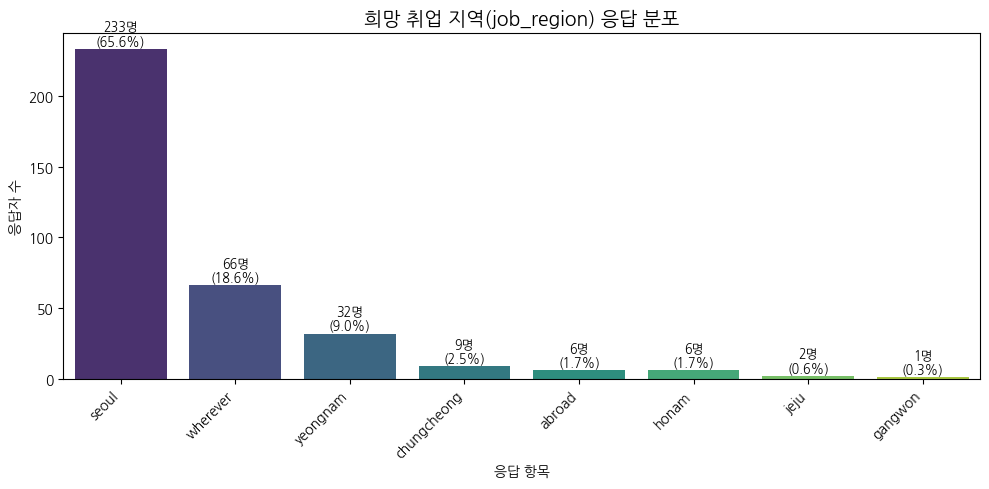

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# ✅ 한글 폰트 설정 (Linux 환경 기준)
plt.rcParams['font.family'] = 'NanumGothic'  # 설치되어 있다면
plt.rcParams['axes.unicode_minus'] = False

def plot_factor_distribution(df, prefix, title):
    """
    원핫인코딩된 범주형 응답(prefix)을 막대그래프로 시각화
    """
    cols = [col for col in df.columns if col.startswith(prefix)]
    counts = df[cols].sum().sort_values(ascending=False)
    total = len(df)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts.index.str.replace(f"{prefix}_", ""), y=counts.values, palette="viridis")

    plt.title(f"{title} 응답 분포", fontsize=14)
    plt.xlabel("응답 항목")
    plt.ylabel("응답자 수")
    plt.xticks(rotation=45, ha='right')

    # 막대 위에 숫자 + 퍼센트 표시
    for i, v in enumerate(counts.values):
        plt.text(i, v + 1, f"{int(v)}명\n({v/total*100:.1f}%)", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


# ✅ major_factor 응답 분포
plot_factor_distribution(df, "major_factor", "전공 선택 요인(major_factor)")

# ✅ job_region 응답 분포
plot_factor_distribution(df, "job_region", "희망 취업 지역(job_region)")


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\3431809919.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


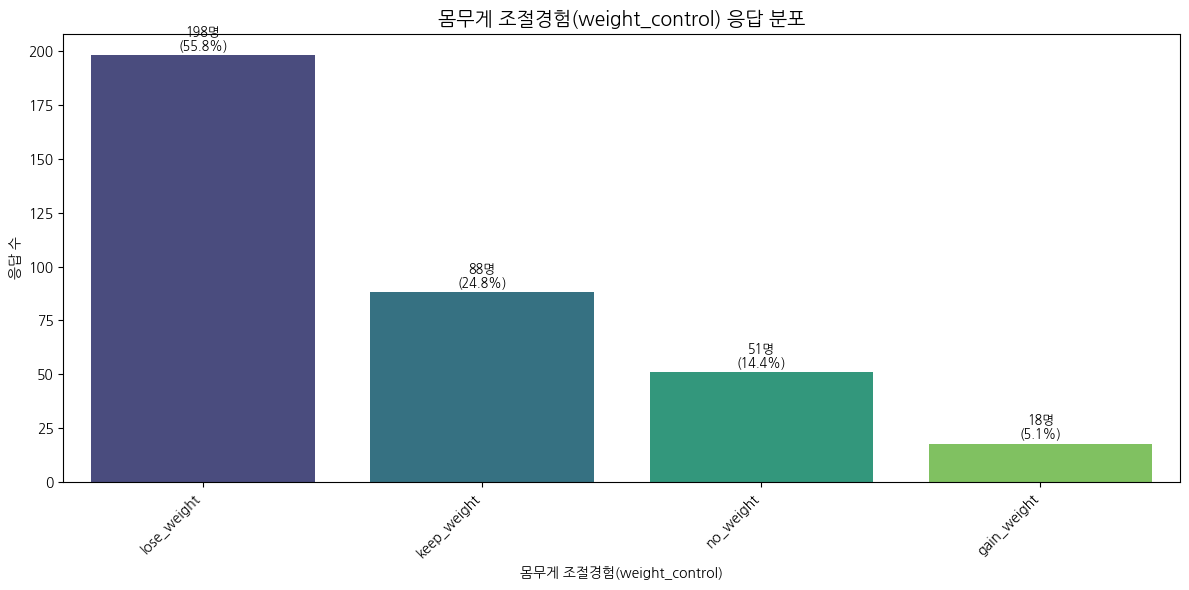

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\3431809919.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


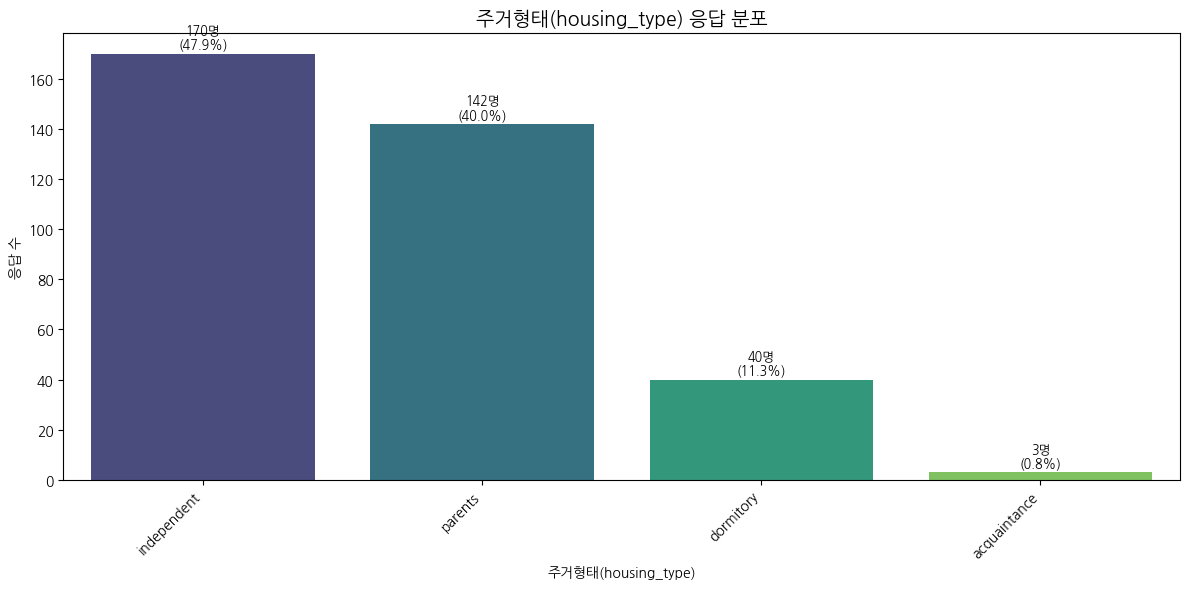

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\3431809919.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


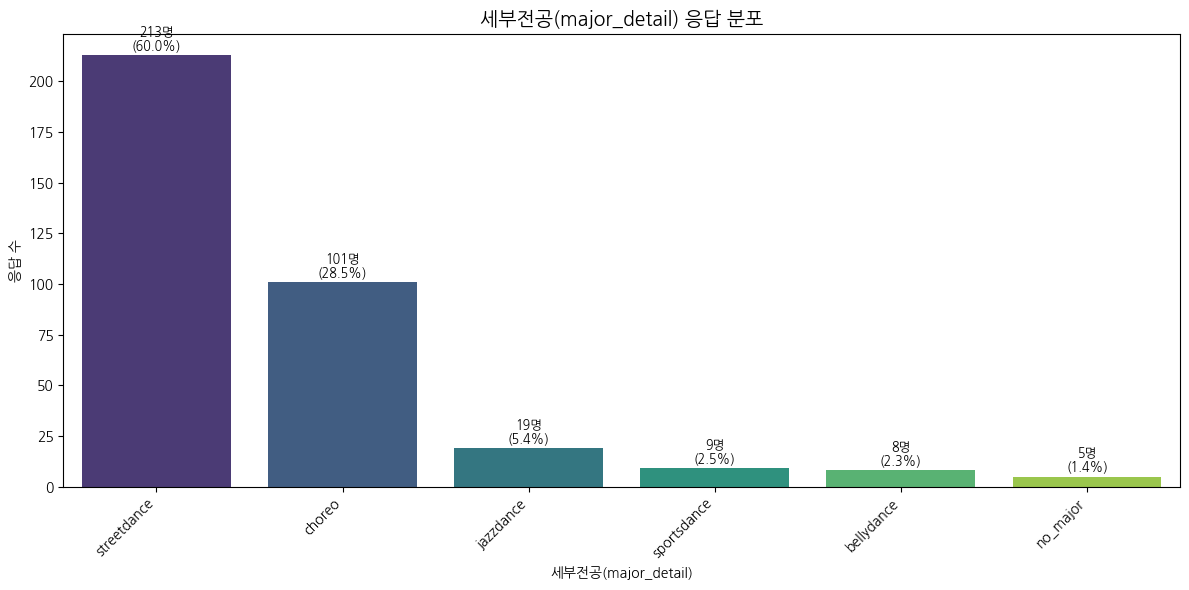

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\3431809919.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


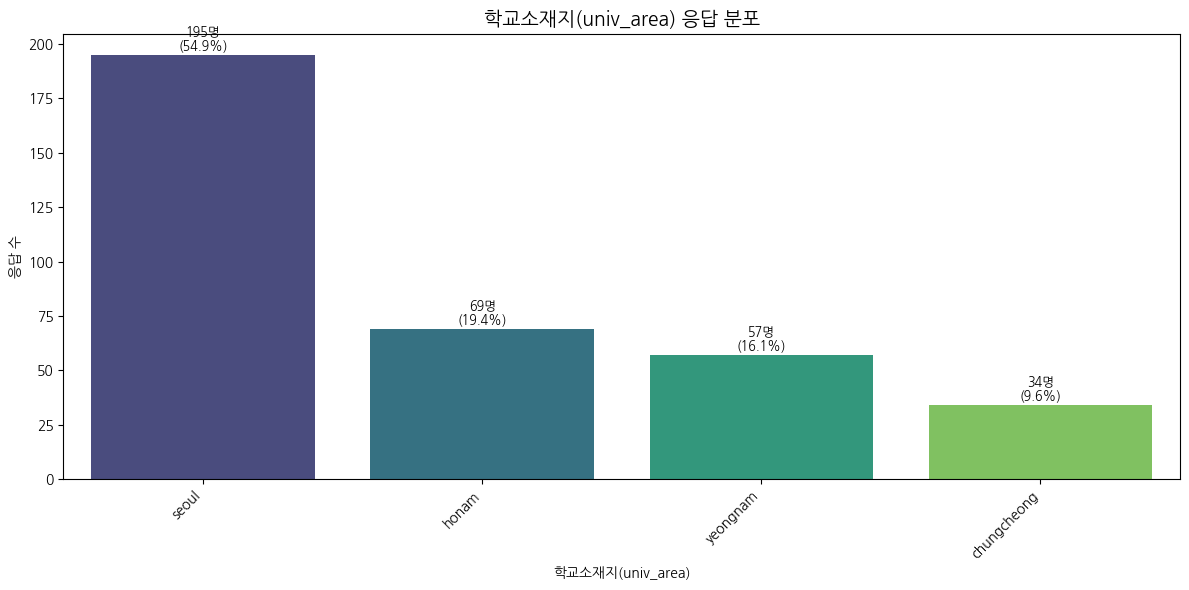

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_42920\3431809919.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


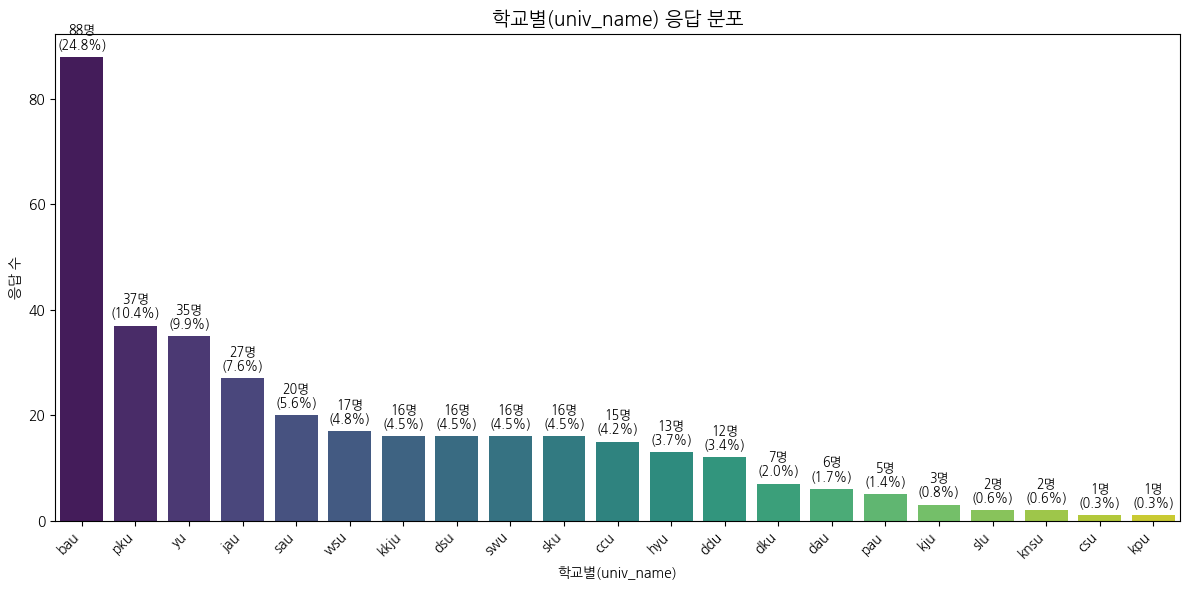

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 공통 시각화 함수
def plot_factor(df, prefix, title):
    cols = [col for col in df.columns if col.startswith(prefix)]
    counts = df[cols].sum().sort_values(ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(
        x=counts.index.str.replace(f'{prefix}_', ''), 
        y=counts.values, 
        palette='viridis'
    )

    plt.title(f"{title} 응답 분포", fontsize=14)
    plt.xlabel(title)
    plt.ylabel("응답 수")
    plt.xticks(rotation=45, ha='right')

    total = len(df)
    for i, v in enumerate(counts.values):
        pct = v / total * 100
        plt.text(i, v + 1, f"{int(v)}명\n({pct:.1f}%)", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# ✅ weight_control (전공 선택 요인)
plot_factor(df, 'weight_control', '몸무게 조절경험(weight_control)')

# ✅ housing_type (주거형태)
plot_factor(df, 'housing_type', '주거형태(housing_type)')

plot_factor(df, 'major_detail', '세부전공(major_detail)')

plot_factor(df, 'univ_area', '학교소재지(univ_area)')

plot_factor(df, 'univ_name', '학교별(univ_name)')